# Práctica 1 · Óptica Geométrica — Análisis de Datos (Externa vs Interna)
**Generado automáticamente:** 2025-08-17 20:26

Este cuaderno **analiza únicamente tus datos** y está documentado para explicar el procedimiento completo:
1. Estructura y limpieza de datos.
2. **Reflexión** (externa e interna): \(\theta_r\) vs \(\theta_i\) y residuos.
3. **Snell** en **externa** (aire→acrílico).
4. **Snell** en **interna** (acrílico→aire) usando solo **pre-crítico**.
5. **Comparación** entre integrantes (boxplots, ANOVA) y resumen.

**Nota:** No se incluye la predicción del ángulo crítico; el enfoque es validación de leyes y estimación de \(n\) con tus mediciones.


## 0) Librerías e idea estadística
- `pandas`/`numpy` para datos; `matplotlib` para gráficas.
- Ajustes por **mínimos cuadrados**:
  - Reflexión: \(\theta_r = a + b\,\theta_i\) (esperado \(a=0\), \(b=1\)).
  - Snell externa: \(\sin\theta_i = m\,\sin\theta_t\) (por el **origen**), con \(m\approx n_2/n_1\).
  - Snell interna (pre-crítico): \(\sin\theta_t = m\,\sin\theta_i\) (por el **origen**), con \(m\approx n_1/n_2\).
- Reportamos **IC95%** para pendientes y añadimos **conclusiones por figura**.


In [1]:
# === Importaciones ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
deg2rad = np.pi/180  # grados→radianes
plt.rcParams['figure.figsize'] = (8,5)


## 1) Datos de entrada — **tus mediciones (actualizadas)**
Puedes editar aquí para corregir o extender valores. Todas las listas están en **grados**.


In [2]:
# -----------------------------
# Incidencia EXTERNA (aire → acrílico)
# -----------------------------
angles = [5,10,15,20,25,30,35,40,45,50,55,60]
# Alejandro
r_A = [6,11,16,21,26,32,36,44,49,55,59,64]
t_A = [5,8,12,16,18,21,25,31,33,36,38,42]
# Yael
r_Y = [6,11,17,21,26,31,37,44,48,54,59,64]
t_Y = [5,9,12,16,19,22,26,31,33,36,38,41]
# Héctor
r_H = [6,12,16,21,26,31,37,49,48,54,59,64]
t_H = [5,9,12,15,19,21,25,30,33,36,33,41]

def mk(persona, rr, tt):
    """Crea un DataFrame para una persona y condición externa."""
    return pd.DataFrame({
        'persona': persona,
        'theta_i_deg': angles,
        'theta_r_deg': rr,
        'theta_t_deg': tt,
        'condicion': 'externa'
    })

ext = pd.concat([mk('Alejandro', r_A, t_A),
                 mk('Yael', r_Y, t_Y),
                 mk('Hector', r_H, t_H)], ignore_index=True)

# -----------------------------
# Incidencia INTERNA (acrílico → aire)
# -----------------------------
# Alejandro
A_i = [5,10,15,20,25,30,35,40,45,50]
A_r = [8,13,16,21,28,33,37,42,47,51]
A_t = [8,21,26,33,34,54,64,83,47,51]
# Yael
Y_i = [5,10,15,20,25,30,35,40,45,50]
Y_r = [8,13,16,21,28,32,37,42,47,51]
Y_t = [13,20,26,33,46,54,64,82,47,51]
# Héctor
H_i = [5,10,15,20,25,30,35,40,45,50]
H_r = [8,12,16,21,28,32,37,41,47,50]
H_t = [8,20,26,33,45,54,64,82,47,50]

def mk_int(nombre, ii, rr, tt):
    return pd.DataFrame({
        'persona': nombre,
        'theta_i_deg': ii,
        'theta_r_deg': rr,
        'theta_t_deg': tt,
        'condicion': 'interna'
    })

intraw = pd.concat([mk_int('Alejandro', A_i, A_r, A_t),
                    mk_int('Yael', Y_i, Y_r, Y_t),
                    mk_int('Hector', H_i, H_r, H_t)], ignore_index=True)

display(ext.head()); display(intraw.head())

,persona,theta_i_deg,theta_r_deg,theta_t_deg,condicion
0,Alejandro,5,6,5,externa
1,Alejandro,10,11,8,externa
2,Alejandro,15,16,12,externa
3,Alejandro,20,21,16,externa
4,Alejandro,25,26,18,externa


,persona,theta_i_deg,theta_r_deg,theta_t_deg,condicion
0,Alejandro,5,8,8,interna
1,Alejandro,10,13,21,interna
2,Alejandro,15,16,26,interna
3,Alejandro,20,21,33,interna
4,Alejandro,25,28,34,interna


## 2) Derivados y limpieza mínima
- Convertimos a **radianes** y calculamos \(\sin\theta\).
- En **interna**, marcamos **post-crítico** (solo para limpieza de Snell): `θt ≥ 80°` o `θt ≈ θr`.


In [3]:
for df_ in (ext, intraw):
    df_['theta_i_rad'] = df_['theta_i_deg']*deg2rad
    df_['theta_r_rad'] = df_['theta_r_deg']*deg2rad
    df_['theta_t_rad'] = df_['theta_t_deg']*deg2rad
    df_['sin_i'] = np.sin(df_['theta_i_rad'])
    df_['sin_t'] = np.sin(df_['theta_t_rad'])

intraw['post_critico'] = (intraw['theta_t_deg']>=80) | (np.isclose(intraw['theta_t_deg'], intraw['theta_r_deg']))
intl = intraw[~intraw['post_critico']].copy()
print('Interna: total =', len(intraw), '| pre-crítico usado =', len(intl))

Interna: total = 30 | pre-crítico usado = 19


## 3) Ley de **reflexión** (externa e interna)
Ajustamos \(\theta_r = a + b\,\theta_i\) y graficamos **θr vs θi** y **residuos** para **externa** e **interna**.


Reflexión (externa, global): a=0.136, b=1.0727, IC95[b]=(np.float64(1.047934295991158), np.float64(1.0975202494633876)), R2=0.9956


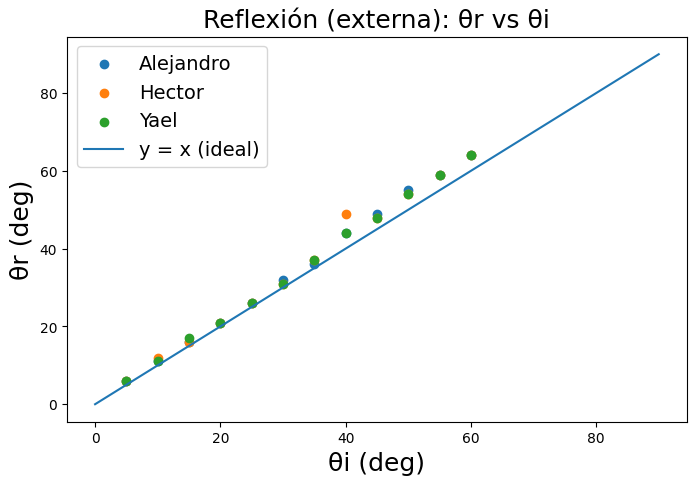

Conclusión: Los datos externos siguen y≈x; la ley de reflexión se verifica con pequeñas desviaciones atribuibles a lectura/alineación.


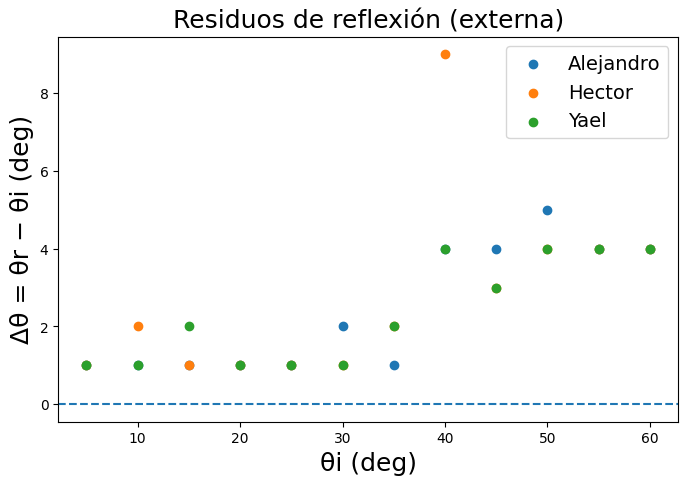

Conclusión: Δθ se concentra alrededor de 0° sin tendencia con θi; algún punto aislado puede tratarse como atípico controlado.
Reflexión (interna, global): a=2.600, b=0.9758, IC95[b]=(np.float64(0.9547451300867986), np.float64(0.9967700214283528)), R2=0.9969


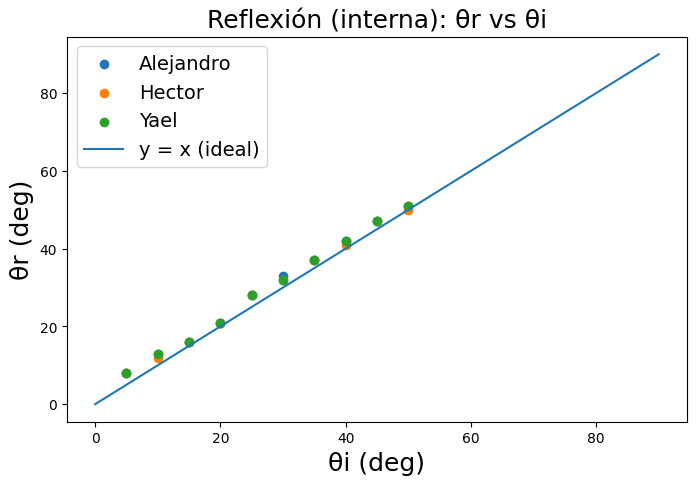

Conclusión: En interna también se verifica θr≈θi; los puntos siguen y=x con R² alto, validando la ley de reflexión dentro del bloque.


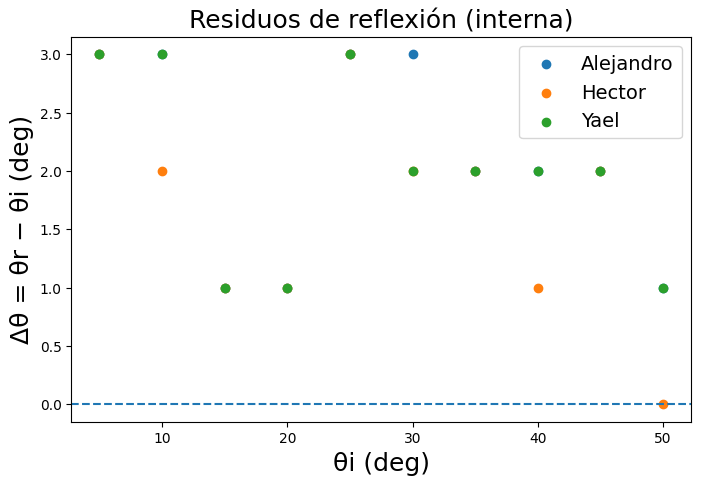

Conclusión: Los residuos en interna se agrupan cerca de 0°; no se observa sesgo con θi, lo que respalda la calidad de las lecturas internas.


In [8]:
def ols_reflexion(x_deg, y_deg):
    """Ajuste OLS de θr = a + b θi con IC95% y R²."""
    x = np.asarray(x_deg); y = np.asarray(y_deg)
    n = len(x)
    xb, yb = x.mean(), y.mean()
    Sxx = np.sum((x-xb)**2)
    Sxy = np.sum((x-xb)*(y-yb))
    b = Sxy/Sxx
    a = yb - b*xb
    yhat = a + b*x
    s2 = np.sum((y-yhat)**2)/(n-2)
    se_b = np.sqrt(s2/Sxx)
    se_a = np.sqrt(s2*(1/n + xb**2/Sxx))
    tcrit = stats.t.ppf(0.975, df=n-2)
    ci_b = (b - tcrit*se_b, b + tcrit*se_b)
    ci_a = (a - tcrit*se_a, a + tcrit*se_a)
    R2 = 1 - np.sum((y-yhat)**2)/np.sum((y-yb)**2)
    return a, b, ci_a, ci_b, R2

# ===== Reflexión EXTERNA =====
a,b,ci_a,ci_b,R2 = ols_reflexion(ext['theta_i_deg'], ext['theta_r_deg'])
print(f"Reflexión (externa, global): a={a:.3f}, b={b:.4f}, IC95[b]={ci_b}, R2={R2:.4f}")
for persona, g in ext.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['theta_r_deg'], label=persona)
x = np.linspace(0, 90, 181)
plt.plot(x, x, label='y = x (ideal)')
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('θr (deg)',fontsize=18); plt.title('Reflexión (externa): θr vs θi',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: Los datos externos siguen y≈x; la ley de reflexión se verifica con pequeñas desviaciones atribuibles a lectura/alineación.')

ext['delta_ref_deg'] = ext['theta_r_deg'] - ext['theta_i_deg']
for persona, g in ext.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['delta_ref_deg'], label=persona)
plt.axhline(0, linestyle='--')
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('Δθ = θr − θi (deg)',fontsize=18); plt.title('Residuos de reflexión (externa)',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: Δθ se concentra alrededor de 0° sin tendencia con θi; algún punto aislado puede tratarse como atípico controlado.')

# ===== Reflexión INTERNA (NUEVO) =====
ai,bi,ci_ai,ci_bi,R2i = ols_reflexion(intraw['theta_i_deg'], intraw['theta_r_deg'])
print(f"Reflexión (interna, global): a={ai:.3f}, b={bi:.4f}, IC95[b]={ci_bi}, R2={R2i:.4f}")
for persona, g in intraw.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['theta_r_deg'], label=persona)
plt.plot(x, x, label='y = x (ideal)')
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('θr (deg)',fontsize=18); plt.title('Reflexión (interna): θr vs θi',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: En interna también se verifica θr≈θi; los puntos siguen y=x con R² alto, validando la ley de reflexión dentro del bloque.')

intraw['delta_ref_deg'] = intraw['theta_r_deg'] - intraw['theta_i_deg']
for persona, g in intraw.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['delta_ref_deg'], label=persona)
plt.axhline(0, linestyle='--')
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('Δθ = θr − θi (deg)',fontsize=18); plt.title('Residuos de reflexión (interna)',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: Los residuos en interna se agrupan cerca de 0°; no se observa sesgo con θi, lo que respalda la calidad de las lecturas internas.')


## 4) Snell — **Externa** (aire→acrílico)
Ajuste por el **origen** \(\sin\theta_i = m\,\sin\theta_t\) y estabilidad de \(n_{est}=\sin\theta_i/\sin\theta_t\).


Externa (Snell): m=1.3140  IC95%=(np.float64(1.294868633722513), np.float64(1.3331130911435018))


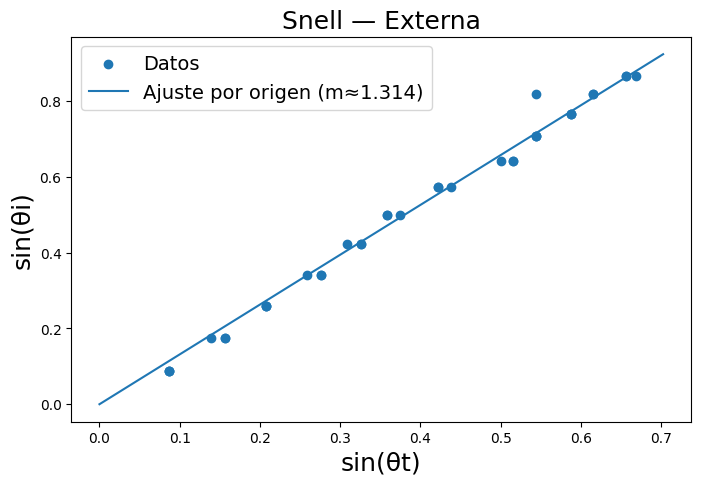

Conclusión: Relación aproximadamente lineal; la pendiente m subestima el n tabulado, sugiriendo sesgo de alineación/lectura en externa.


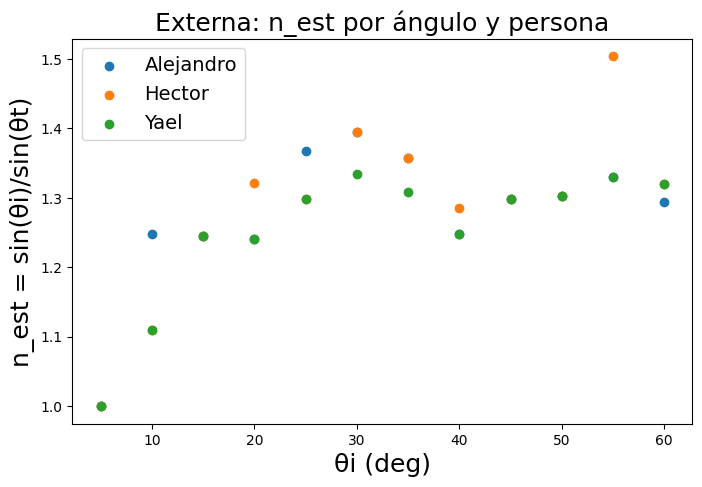

Conclusión: n_est ~constante con cierta dispersión; la estabilidad mejora evitando ángulos extremos y afinando la normal.


In [5]:
def slope_through_origin(x, y):
    """Ajuste y = m x con error estándar de m."""
    x = np.asarray(x); y = np.asarray(y)
    m = (x@y)/(x@x)
    n = len(x); yhat = m*x
    s2 = np.sum((y - yhat)**2)/(n-1)
    se = np.sqrt(s2/np.sum(x**2))
    return m, se

m_ext, se_ext = slope_through_origin(ext['sin_t'], ext['sin_i'])
ci_ext = (m_ext - 1.96*se_ext, m_ext + 1.96*se_ext)
print(f"Externa (Snell): m={m_ext:.4f}  IC95%={ci_ext}")

plt.scatter(ext['sin_t'], ext['sin_i'], label='Datos')
xx = np.linspace(0, ext['sin_t'].max()*1.05, 200)
plt.plot(xx, m_ext*xx, label=f'Ajuste por origen (m≈{m_ext:.3f})')
plt.xlabel('sin(θt)',fontsize=18); plt.ylabel('sin(θi)',fontsize=18); plt.title('Snell — Externa',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: Relación aproximadamente lineal; la pendiente m subestima el n tabulado, sugiriendo sesgo de alineación/lectura en externa.')

ext['n_est'] = ext['sin_i']/ext['sin_t']
for persona, g in ext.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['n_est'], label=persona)
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('n_est = sin(θi)/sin(θt)',fontsize=18); plt.title('Externa: n_est por ángulo y persona',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: n_est ~constante con cierta dispersión; la estabilidad mejora evitando ángulos extremos y afinando la normal.')


## 5) Snell — **Interna** (acrílico→aire, pre-crítico)
Ajuste por el **origen** \(\sin\theta_t = m\,\sin\theta_i\) y estabilidad de \(n_{est}=\sin\theta_t/\sin\theta_i\).


Interna (pre): m=1.6078  IC95%=(np.float64(1.5527439246090666), np.float64(1.6628004053483556))


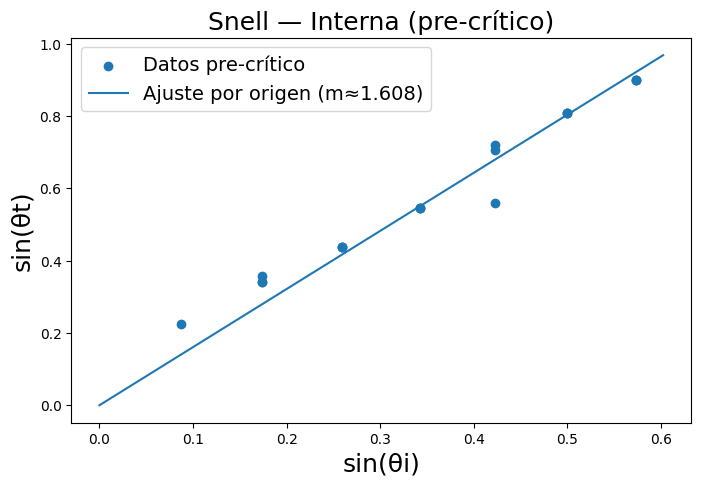

Conclusión: Linealidad nítida y pendiente cercana al valor tabulado; la interna es más robusta para estimar n en este montaje.


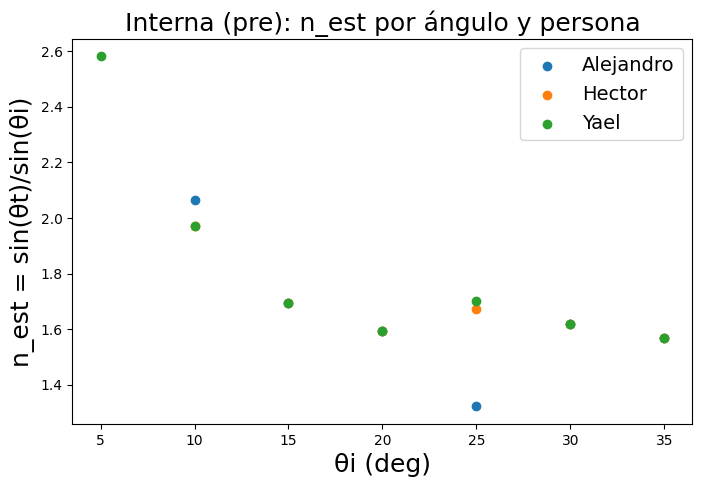

Conclusión: n_est más concentrado que en externa; mejor repetibilidad y menor sesgo.


In [6]:

m_int, se_int = slope_through_origin(intl['sin_i'], intl['sin_t'])
ci_int = (m_int - 1.96*se_int, m_int + 1.96*se_int)
print(f"Interna (pre): m={m_int:.4f}  IC95%={ci_int}")

plt.scatter(intl['sin_i'], intl['sin_t'], label='Datos pre-crítico')
xxx = np.linspace(0, intl['sin_i'].max()*1.05, 200)
plt.plot(xxx, m_int*xxx, label=f'Ajuste por origen (m≈{m_int:.3f})')
plt.xlabel('sin(θi)',fontsize=18); plt.ylabel('sin(θt)',fontsize=18); plt.title('Snell — Interna (pre-crítico)',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: Linealidad nítida y pendiente cercana al valor tabulado; la interna es más robusta para estimar n en este montaje.')

intl['n_est'] = intl['sin_t']/intl['sin_i']
for persona, g in intl.groupby('persona'):
    plt.scatter(g['theta_i_deg'], g['n_est'], label=persona)
plt.xlabel('θi (deg)',fontsize=18); plt.ylabel('n_est = sin(θt)/sin(θi)',fontsize=18); plt.title('Interna (pre): n_est por ángulo y persona',fontsize=18)
plt.legend(fontsize=14); plt.show()
print('Conclusión: n_est más concentrado que en externa; mejor repetibilidad y menor sesgo.')


## 6) Comparaciones: Boxplots y ANOVA
Comparamos \(n_{est}\) por persona en **externa** e **interna (pre)** y probamos diferencias con **ANOVA**.


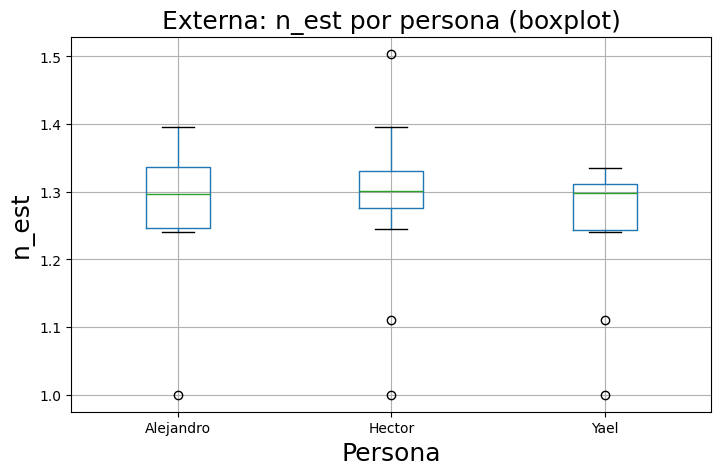

ANOVA Externa: F=0.290, p=0.7504
Conclusión: p alto → sin diferencias significativas entre integrantes en externa.


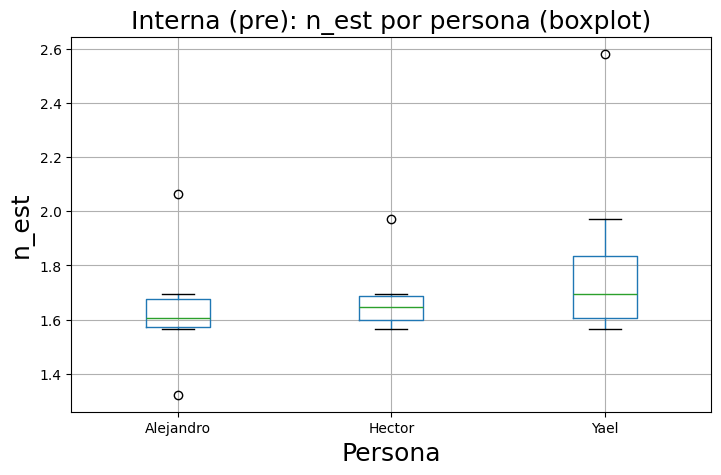

ANOVA Interna (pre): F=0.738, p=0.4938
Conclusión: p alto → diferencias no significativas; interna muestra menor dispersión en cajas.


In [7]:
# Boxplot Externa
ext.boxplot(column='n_est', by='persona')
plt.title('Externa: n_est por persona (boxplot)',fontsize=18); plt.suptitle('')
plt.xlabel('Persona',fontsize=18); plt.ylabel('n_est',fontsize=18); plt.show()

groups_ext = [g['n_est'].values for _, g in ext.groupby('persona')]
Fext, pext = stats.f_oneway(*groups_ext)
print(f"ANOVA Externa: F={Fext:.3f}, p={pext:.4f}")
print('Conclusión: p alto → sin diferencias significativas entre integrantes en externa.')

# Boxplot Interna (pre)
intl.boxplot(column='n_est', by='persona')
plt.title('Interna (pre): n_est por persona (boxplot)',fontsize=18); plt.suptitle('')
plt.xlabel('Persona',fontsize=18); plt.ylabel('n_est',fontsize=18); plt.show()

groups_int = [g['n_est'].values for _, g in intl.groupby('persona')]
Fint, pint = stats.f_oneway(*groups_int)
print(f"ANOVA Interna (pre): F={Fint:.3f}, p={pint:.4f}")
print('Conclusión: p alto → diferencias no significativas; interna muestra menor dispersión en cajas.')


## 7) Resumen
- **Reflexión** se verifica en externa e interna (θr≈θi; R² alto; residuos cerca de 0°).
- **Snell (externa)**: pendiente menor a la esperada → probable sesgo de alineación/lectura de θt.
- **Snell (interna, pre)**: pendiente cercana al acrílico tabulado; mayor estabilidad.
- **Entre personas**: sin diferencias significativas (ANOVA); interna tiene menor dispersión.
